# Balanceo de dataset Website Phishing
Se tiene el siguiente dataset de [Website Phishing](https://archive.ics.uci.edu/dataset/379/website+phishing)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
import requests
import zipfile
import io
import warnings

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")


## 1. Carga y Exploración del Dataset Website Phishing

El dataset Website Phishing contiene información sobre características de sitios web para detectar phishing. Vamos a cargarlo y explorar su estructura.

In [8]:
# Descargar el dataset Website Phishing desde UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00379/PhishingData.arff'
response = requests.get(url)

# Leer el archivo ARFF
from scipy.io import arff
import io

# Convertir el contenido a un objeto StringIO para leerlo
data_arff = arff.loadarff(io.StringIO(response.text))
data = pd.DataFrame(data_arff[0])

# Mostrar información básica del dataset
print("Dimensiones del dataset:", data.shape)
print("\nPrimeras filas del dataset:")
print(data.head())
print("\nInformación del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())


Dimensiones del dataset: (1353, 10)

Primeras filas del dataset:
     SFH popUpWidnow SSLfinal_State Request_URL URL_of_Anchor web_traffic  \
0   b'1'       b'-1'           b'1'       b'-1'         b'-1'        b'1'   
1  b'-1'       b'-1'          b'-1'       b'-1'         b'-1'        b'0'   
2   b'1'       b'-1'           b'0'        b'0'         b'-1'        b'0'   
3   b'1'        b'0'           b'1'       b'-1'         b'-1'        b'0'   
4  b'-1'       b'-1'           b'1'       b'-1'          b'0'        b'0'   

  URL_Length age_of_domain having_IP_Address Result  
0       b'1'          b'1'              b'0'   b'0'  
1       b'1'          b'1'              b'1'   b'1'  
2      b'-1'          b'1'              b'0'   b'1'  
3       b'1'          b'1'              b'0'   b'0'  
4      b'-1'          b'1'              b'0'   b'1'  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353 entries, 0 to 1352
Data columns (total 10 columns):
 #   Column    

## 2. Análisis del Balance de Clases

Columna objetivo: Result

Distribución de clases:
Result
b'-1'    702
b'1'     548
b'0'     103
Name: count, dtype: int64

Porcentajes:
Result
b'-1'    51.884701
b'1'     40.502587
b'0'      7.612712
Name: proportion, dtype: float64

Valores faltantes por columna:
SFH                  0
popUpWidnow          0
SSLfinal_State       0
Request_URL          0
URL_of_Anchor        0
web_traffic          0
URL_Length           0
age_of_domain        0
having_IP_Address    0
Result               0
dtype: int64


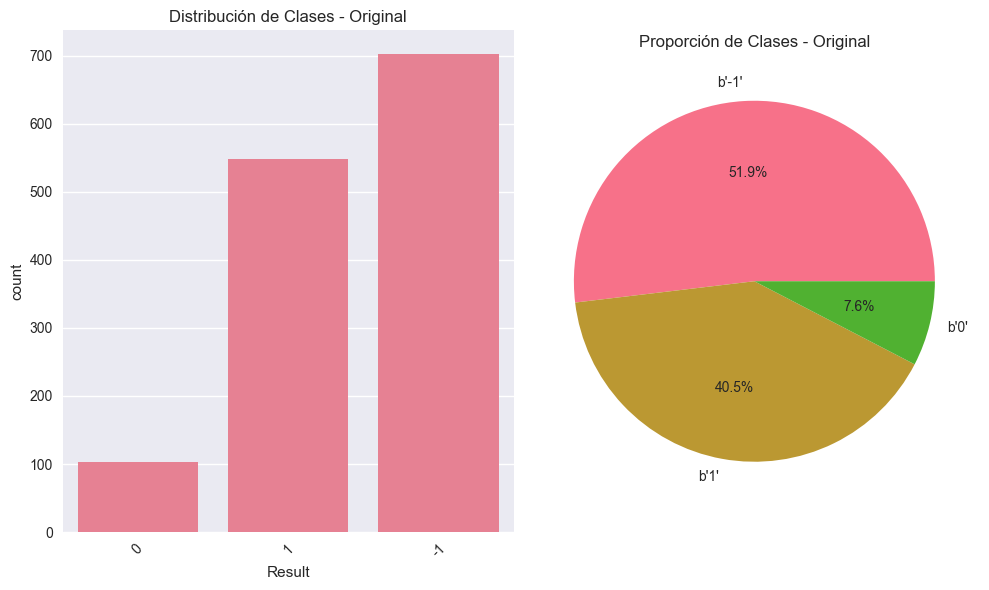


Ratio de desbalance: 6.82
⚠️  El dataset está DESBALANCEADO - se requiere balanceo


In [ ]:
# Identificar la columna objetivo (última columna)
target_column = data.columns[-1]
print(f"Columna objetivo: {target_column}")

# Analizar la distribución de clases
class_distribution = data[target_column].value_counts()
print(f"\nDistribución de clases:")
print(class_distribution)
print(f"\nPorcentajes:")
print(data[target_column].value_counts(normalize=True) * 100)

# Verificar valores faltantes
print(f"\nValores faltantes por columna:")
print(data.isnull().sum())

# Visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=data, x=target_column)
plt.title("Distribución de Clases - Original")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
data[target_column].value_counts().plot(kind="pie", autopct="%1.1f%%")
plt.title("Proporción de Clases - Original")
plt.ylabel("")

plt.tight_layout()
plt.show()

# Calcular el ratio de desbalance
class_counts = data[target_column].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nRatio de desbalance: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("El dataset está DESBALANCEADO - se requiere balanceo")
else:
    print("El dataset está BALANCEADO - no se requiere balanceo")


## 3. Aplicación de Técnicas de Balanceo

Si el dataset está desbalanceado, aplicaremos técnicas de balanceo como SMOTE.

Forma original del dataset: (1353, 9)
Distribución original de clases: [702 103 548]
Clases originales: [b'-1' b'0' b'1']

🔄 Aplicando balanceo con SMOTE...
Aplicando técnica de balanceo: SMOTE
Forma del dataset balanceado: (2106, 9)
Distribución balanceada de clases: [702 702 702]
Clases balanceadas: [0 1 2]

Nueva distribución de clases:
Result
b'0'     702
b'1'     702
b'-1'    702
Name: count, dtype: int64

Nuevos porcentajes:
Result
b'0'     33.333333
b'1'     33.333333
b'-1'    33.333333
Name: proportion, dtype: float64


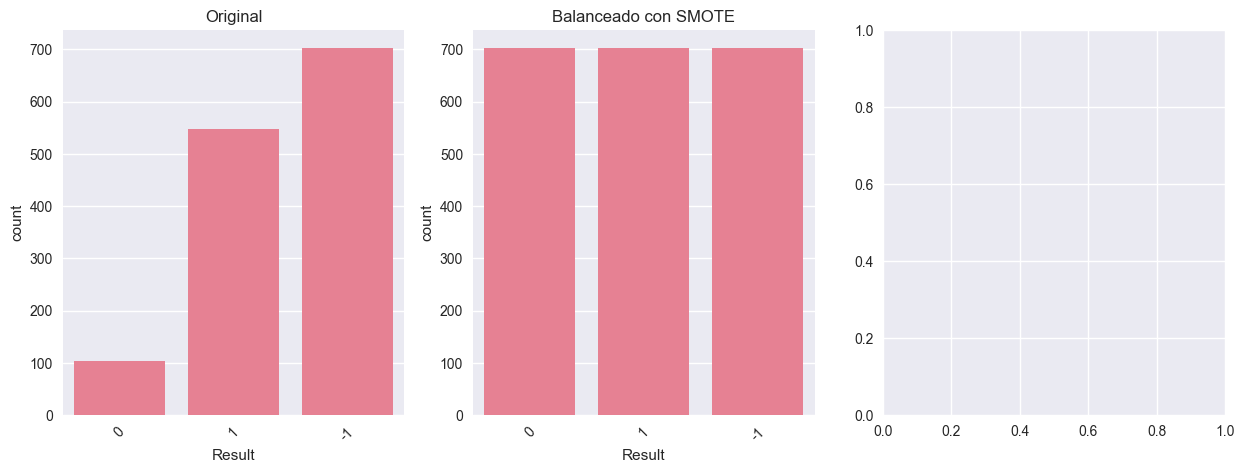

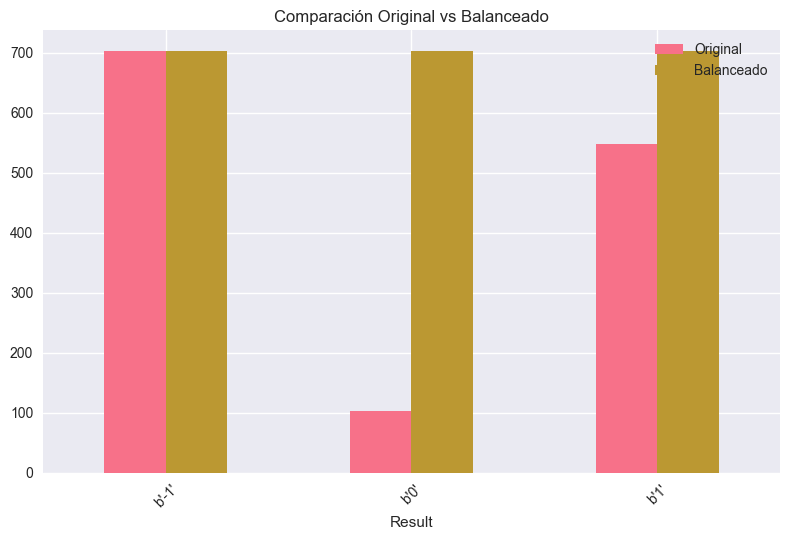

In [ ]:
# Función para aplicar balanceo si es necesario
def balance_dataset(X, y, method="smote"):
    """
    Aplica técnicas de balanceo al dataset
    """
    print(f"Aplicando técnica de balanceo: {method.upper()}")

    if method == "smote":
        # SMOTE: Synthetic Minority Oversampling Technique
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y)

    elif method == "smote_tomek":
        # SMOTE + Tomek Links (combinación de oversampling y undersampling)
        smote_tomek = SMOTETomek(random_state=42)
        X_balanced, y_balanced = smote_tomek.fit_resample(X, y)

    elif method == "undersample":
        # Random Undersampling
        undersampler = RandomUnderSampler(random_state=42)
        X_balanced, y_balanced = undersampler.fit_resample(X, y)

    return X_balanced, y_balanced


# Preparar datos para balanceo
X = data.drop(target_column, axis=1)
y = data[target_column]

# Convertir variables categóricas a numéricas si es necesario
# IMPORTANTE: Usar LabelEncoder separado para la variable objetivo
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Para las características, convertir categóricas a numéricas
X_encoded = X.copy()
le_features = {}  # Diccionario para almacenar encoders de cada columna

for col in X_encoded.columns:
    if X_encoded[col].dtype == "object":
        le_features[col] = LabelEncoder()
        X_encoded[col] = le_features[col].fit_transform(X_encoded[col])

print(f"Forma original del dataset: {X_encoded.shape}")
print(f"Distribución original de clases: {np.bincount(y_encoded)}")
print(f"Clases originales: {le_target.classes_}")

# Aplicar balanceo si el ratio de desbalance es > 1.5
if imbalance_ratio > 1.5:
    print("\n🔄 Aplicando balanceo con SMOTE...")
    X_balanced, y_balanced = balance_dataset(X_encoded, y_encoded, method="smote")

    print(f"Forma del dataset balanceado: {X_balanced.shape}")
    print(f"Distribución balanceada de clases: {np.bincount(y_balanced)}")
    print(f"Clases balanceadas: {np.unique(y_balanced)}")

    # Crear DataFrame balanceado
    balanced_data = pd.DataFrame(X_balanced, columns=X_encoded.columns)

    # Usar el encoder de la variable objetivo para decodificar
    balanced_data[target_column] = le_target.inverse_transform(y_balanced)

    # Mostrar nueva distribución
    print(f"\nNueva distribución de clases:")
    print(balanced_data[target_column].value_counts())
    print(f"\nNuevos porcentajes:")
    print(balanced_data[target_column].value_counts(normalize=True) * 100)

    # Visualizar comparación
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.countplot(data=data, x=target_column)
    plt.title("Original")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 2)
    sns.countplot(data=balanced_data, x=target_column)
    plt.title("Balanceado con SMOTE")
    plt.xticks(rotation=45)

    plt.subplot(1, 3, 3)
    comparison_data = pd.DataFrame(
        {
            "Original": data[target_column].value_counts(),
            "Balanceado": balanced_data[target_column].value_counts(),
        }
    )
    comparison_data.plot(kind="bar")
    plt.title("Comparación Original vs Balanceado")
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Usar el dataset balanceado
    final_data = balanced_data

else:
    print("\n✅ No se requiere balanceo - usando dataset original")
    final_data = data.copy()
    # Asegurar que las variables categóricas estén codificadas
    for col in final_data.columns:
        if final_data[col].dtype == "object" and col != target_column:
            if col not in le_features:
                le_features[col] = LabelEncoder()
            final_data[col] = le_features[col].fit_transform(final_data[col])

## 4. Guardar Dataset Balanceado

In [ ]:
# Guardar el dataset balanceado para uso en otros notebooks
output_file = 'phishing_balanced.csv'
final_data.to_csv(output_file, index=False)

print(f"Dataset balanceado guardado como: {output_file}")
print(f"Dimensiones finales: {final_data.shape}")
print(f"Columnas: {list(final_data.columns)}")

# Mostrar resumen final
print(f"\nRESUMEN FINAL:")
print(f"- Dataset original: {data.shape}")
print(f"- Dataset final: {final_data.shape}")
print(f"- Ratio de desbalance original: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    final_ratio = final_data[target_column].value_counts().max() / final_data[target_column].value_counts().min()
    print(f"- Ratio de desbalance final: {final_ratio:.2f}")
    print(f"- Técnica aplicada: SMOTE")
else:
    print(f"- Técnica aplicada: Ninguna (dataset ya balanceado)")

print(f"\nEl dataset está listo para ser usado en los notebooks de entrenamiento.")

✅ Dataset balanceado guardado como: phishing_balanced.csv
Dimensiones finales: (2106, 10)
Columnas: ['SFH', 'popUpWidnow', 'SSLfinal_State', 'Request_URL', 'URL_of_Anchor', 'web_traffic', 'URL_Length', 'age_of_domain', 'having_IP_Address', 'Result']

📊 RESUMEN FINAL:
- Dataset original: (1353, 10)
- Dataset final: (2106, 10)
- Ratio de desbalance original: 6.82
- Ratio de desbalance final: 1.00
- Técnica aplicada: SMOTE

🎯 El dataset está listo para ser usado en los notebooks de entrenamiento.
